In [1]:
import os
import zarr
import timm
import random
import json
import gc
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict

import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from tqdm import tqdm
from src.kaggle_notebook_metric import compute_lb, extract_particle_results
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

import wandb
from pathlib import Path

notebook_name = os.path.join(Path().resolve()).split("/")[-1]

param = {
    "model": CFG.model_name,
    "resolution": CFG.resolution,
    "augmentation_prob": CFG.augmentation_prob,
    "slice": CFG.slice_,
    "epochs": CFG.epochs,
    "lr": CFG.lr,
    "batch_size": CFG.batch_size,
    "weight_decay": CFG.weight_decay,
    "num_workers": CFG.num_workers,
    "augment_data_ratio": CFG.augment_data_ratio,
}

In [2]:
from sklearn.metrics import *
from scipy.optimize import minimize

# sikii値とexp_namesを入れるとスコアを出力する関数


def compute_score(sikii_list, inferenced_array, exp_name):
    apo_ferritin = sikii_list[0]
    beta_amylase = sikii_list[1]
    beta_galactosidase = sikii_list[2]
    ribosome = sikii_list[3]
    thyroglobulin = sikii_list[4]
    virus_like_particle = sikii_list[5]

    sikii_dict = {
        "apo-ferritin": apo_ferritin,
        "beta-amylase": beta_amylase,
        "beta-galactosidase": beta_galactosidase,
        "ribosome": ribosome,
        "thyroglobulin": thyroglobulin,
        "virus-like-particle": virus_like_particle,
    }

    all_pred = []

    pred_df = inference2pos(
        pred_segmask=inferenced_array, exp_name=exp_name, sikii_dict=sikii_dict
    )

    all_pred.append(pred_df)

    gc.collect()

    pred_df = pd.concat(all_pred, axis=0).reset_index(drop=True)
    pred_df = pred_df[pred_df["particle_type"] != "beta-amylase"]
    pred_df = pred_df.drop_duplicates(
        subset=["experiment", "x", "y", "z"], keep="first"
    ).reset_index(drop=True)
    pred_df = pred_df.reset_index().rename(columns={"index": "id"})

    gt_df = create_gt_df("../../inputs/train/overlay/ExperimentRuns/", [exp_name])

    result_df, lb_score = compute_lb(
        pred_df, "../../inputs/train/overlay/ExperimentRuns/", [exp_name]
    )

    return lb_score


def reduce_computation_sikii_search(
    inferenced_array: np.ndarray, exp_name: str, threshold_candidates: list[float]
) -> tuple[list[float], float]:
    """
    # How
    6つのしきい値が互いに独立してスコアに貢献しているという前提で、
    1次元ずつ最適なしきい値を探す手法を実装する.

    1. 初期の best_thresholds (全要素 0.5 など適当な値) を用意
    2. i=0 から i=5 まで順番に:
       - threshold_candidates をすべて試し、他は固定したまま i 番目だけ変化させてスコアを計算
       - 最良スコアが得られる候補値を確定し、best_thresholds[i] とする
    3. 全部決まったら最終的なスコアを計算して返す

    これにより、全組み合わせ (product) を回すよりも計算量が大幅に減少する.
    """
    # Why not: 6値独立であるという前提が満たされていない場合、近似解になる可能性あり
    best_thresholds = [0.5] * 6  # 適当な初期値でOK

    for i in tqdm(range(6)):
        best_local_score = -float("inf")
        best_local_value = None

        for candidate in threshold_candidates:
            current_thresholds = best_thresholds[:]  # 現在のベストを複製
            current_thresholds[i] = candidate
            score = compute_score(current_thresholds, inferenced_array, exp_name)
            if score > best_local_score:
                best_local_score = score
                best_local_value = candidate

        # i番目のしきい値を最適値に更新
        best_thresholds[i] = best_local_value

    final_score = compute_score(best_thresholds, inferenced_array, exp_name)
    return best_thresholds, final_score

In [3]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = mixup(
    #         tomogram, segmentation_map, alpha=mixup_alpha
    #     )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 256, 256])


In [4]:
from transformers import get_cosine_schedule_with_warmup

In [5]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [6]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor


padf = PadToSize(CFG.resolution)

In [7]:
for vaild_exp_name in ["TS_73_6", "TS_99_9", "TS_6_4", "TS_69_2", "TS_86_3", "TS_6_6"]:
    wandb.init(
        project="czii2024", name=f"{notebook_name}_{vaild_exp_name}", config=param
    )

    vaild_exp_name = [vaild_exp_name]
    train_exp_name = CFG.train_exp_names.copy()
    train_exp_name.remove(vaild_exp_name[0])

    # valid_exp_name[0]の名前でディレクトリを作成
    os.makedirs(f"./{vaild_exp_name[0]}", exist_ok=True)

    train_dataset = EziiDataset(
        exp_names=train_exp_name,
        base_dir="../../inputs/train/",
        particles_name=CFG.particles_name,
        resolution=CFG.resolution,
        zarr_type=CFG.train_zarr_types,
        train=True,
        augmentation=True,
        slice=True,
        pre_read=True,
    )
    valid_dataset = EziiDataset(
        exp_names=vaild_exp_name,
        base_dir="../../inputs/train/",
        particles_name=CFG.particles_name,
        resolution=CFG.resolution,
        zarr_type=CFG.valid_zarr_types,
        augmentation=False,
        train=True,
        slice=True,
        pre_read=True,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=CFG.num_workers,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
        num_workers=CFG.num_workers,
    )

    encoder = timm.create_model(
        model_name=CFG.model_name,
        pretrained=True,
        in_chans=3,
        num_classes=0,
        global_pool="",
        features_only=True,
    )
    model = Unet3D(encoder=encoder, num_domains=5).to("cuda")

    optimizer = torch.optim.Adam(
        model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
    )
    criterion = DiceLoss()
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=10,
        num_training_steps=CFG.epochs * len(train_loader),
        # * batch_size,
    )
    scaler = GradScaler()
    seg_loss = SegmentationLoss(criterion)
    padf = PadToSize(CFG.resolution)

    best_model = None
    best_constant = 0
    best_score = -100
    best_particle_score = {}

    grand_train_loss = []
    grand_valid_loss = []
    grand_train_score = []
    grand_valid_score = []

    for epoch in range(CFG.epochs):
        model.train()
        train_loss = []
        valid_loss = []
        with tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]"
        ) as tq:
            for data in tq:
                normalized_tomogram = data["normalized_tomogram"]
                segmentation_map = data["segmentation_map"]
                zarr_embedding_idx = data["zarr_type_embedding_idx"]

                normalized_tomogram = padf(normalized_tomogram)
                segmentation_map = padf(segmentation_map)

                # データ拡張
                normalized_tomogram, segmentation_map = augment_data(
                    normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
                )
                normalized_tomogram = normalized_tomogram.cuda()
                segmentation_map = segmentation_map.long().cuda()
                zarr_embedding_idx = zarr_embedding_idx.cuda()

                optimizer.zero_grad()

                with autocast():
                    pred = model(
                        preprocess_tensor(normalized_tomogram), zarr_embedding_idx
                    )
                    loss = seg_loss(pred, segmentation_map)
                # loss.backward()
                # optimizer.step()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                train_loss.append(loss.item())

                # 確率予測
                prob_pred = torch.softmax(pred, dim=1)
                tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

        del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
        gc.collect()
        torch.cuda.empty_cache()

        with tqdm(
            valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]"
        ) as tq:
            with torch.no_grad():
                for data in tq:
                    normalized_tomogram = data["normalized_tomogram"].cuda()
                    segmentation_map = data["segmentation_map"].long().cuda()
                    zarr_embedding_idx = data["zarr_type_embedding_idx"].cuda()

                    normalized_tomogram = padf(normalized_tomogram)
                    segmentation_map = padf(segmentation_map)

                    with autocast():
                        pred = model(
                            preprocess_tensor(normalized_tomogram), zarr_embedding_idx
                        )
                        loss = seg_loss(pred, segmentation_map)
                    valid_loss.append(loss.item())

                    # 確率予測
                    prob_pred = torch.softmax(pred, dim=1)
                    tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

        del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
        gc.collect()
        torch.cuda.empty_cache()

        # # ############### validation ################
        train_nshuffle_original_tomogram = defaultdict(list)
        train_nshuffle_pred_tomogram = defaultdict(list)
        train_nshuffle_gt_tomogram = defaultdict(list)

        valid_original_tomogram = defaultdict(list)
        valid_pred_tomogram = defaultdict(list)
        valid_gt_tomogram = defaultdict(list)

        train_mean_scores = []
        valid_mean_scores = []

        # モデルの保存
        make_dir_ = (
            f"../../../../../../../../mnt/d/kaggle-tmp-models/czii2024/{notebook_name}/"
        )
        os.makedirs(make_dir_, exist_ok=True)
        torch.save(model.state_dict(), make_dir_ + f"model_{epoch}.pth")

        # ############### validation ################
        train_nshuffle_original_tomogram = defaultdict(list)
        train_nshuffle_pred_tomogram = defaultdict(list)
        train_nshuffle_gt_tomogram = defaultdict(list)

        valid_original_tomogram = defaultdict(list)
        valid_pred_tomogram = defaultdict(list)
        valid_gt_tomogram = defaultdict(list)

        train_mean_scores = []
        valid_mean_scores = []

        train_inferenced_array = {}
        train_pred_array = []
        train_gt_array = []
        valid_inferenced_array = {}
        valid_gt_array = []

        # for exp_name in tqdm(CFG.train_exp_names):
        for exp_name in vaild_exp_name:  # 5つのデータで試す
            # inferenced_array = inference(model, exp_name, train=False)
            inferenced_array, n_tomogram, segmentation_map = inference(
                model, exp_name, train=False
            )
            valid_inferenced_array[exp_name] = inferenced_array
            base_dir = "../../inputs/train/overlay/ExperimentRuns/"
            gt_df = create_gt_df(base_dir, [exp_name])
            valid_gt_array.append(gt_df)

        valid_gt_array = pd.concat(valid_gt_array)

        b_constant = 0
        b_score = -100
        b_particle_score = {}

        try:
            best_thresholds, final_score = reduce_computation_sikii_search(
                inferenced_array,
                exp_name,
                [
                    0.05,
                    0.1,
                    0.15,
                    0.2,
                    0.25,
                    0.3,
                    0.35,
                    0.4,
                    0.45,
                    0.5,
                    0.55,
                    0.6,
                    0.65,
                    0.7,
                    0.75,
                ],
            )
        except:
            best_thresholds = [0.5] * 6
            final_score = -50

        b_score = final_score
        b_particle_constant = {
            "apo-ferritin": best_thresholds[0],
            "beta-amylase": best_thresholds[1],
            "beta-galactosidase": best_thresholds[2],
            "ribosome": best_thresholds[3],
            "thyroglobulin": best_thresholds[4],
            "virus-like-particle": best_thresholds[5],
        }

        try:
            valid_pred_array = []
            for exp_name in [vaild_exp_name[0]]:
                pred_df = inference2pos(
                    pred_segmask=valid_inferenced_array[exp_name],
                    exp_name=exp_name,
                    sikii_dict=b_particle_constant,
                )
                valid_pred_array.append(pred_df)

            valid_pred_array = pd.concat(valid_pred_array)

            if len(valid_pred_array) != 0:
                result_df, score_ = compute_lb(
                    valid_pred_array,
                    "../../inputs/train/overlay/ExperimentRuns/",
                    vaild_exp_name,
                )
                particle_score = extract_particle_results(result_df)

                b_score = score_
                b_particle_score = particle_score
        except:
            b_score = -50
            b_particle_score = {}

        import gc
        import torch.cuda as cuda

        # del valid_pred_array, valid_gt_array
        gc.collect()
        cuda.empty_cache()

        # print("constant", b_constant, "score", b_score)

        # wandb-log
        train_info = {
            "01_epoch": epoch,
            "02_train_loss": np.mean(train_loss),
            "03_valid_loss": np.mean(valid_loss),
            # "train_score": np.mean(train_mean_scores),
            "04_valid_best_score": b_score,
        }
        train_info = {**train_info, **b_particle_score}
        train_info = {**train_info, **b_particle_constant}
        wandb.log(train_info)

        # score-update
        if b_score > best_score:
            best_score = b_score
            # best_score = np.mean(valid_mean_scores)
            best_model = model.state_dict()
            torch.save(best_model, f"./{vaild_exp_name[0]}/best_model.pth")

        print(
            f"train-epoch-loss:{np.mean(train_loss):.4f}",
            # f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
            # f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
            f"valid-beta4-score:{b_score:.4f}",
        )

        grand_train_loss.append(np.mean(train_loss))
        # grand_valid_loss.append(np.mean(valid_loss))
        # grand_train_score.append(np.mean(train_mean_scores))
        grand_valid_score.append(b_score)

    del model, optimizer, criterion, scheduler, scaler, seg_loss
    gc.collect()
    torch.cuda.empty_cache()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tatuya (latent-walkers). Use `wandb login --relogin` to force relogin


100%|██████████| 6/6 [03:31<00:00, 35.32s/it]


train-epoch-loss:0.8478 valid-beta4-score:0.2825


100%|██████████| 6/6 [03:24<00:00, 34.11s/it]


train-epoch-loss:0.7570 valid-beta4-score:0.4969


100%|██████████| 6/6 [03:33<00:00, 35.63s/it]


train-epoch-loss:0.6677 valid-beta4-score:0.7058


100%|██████████| 6/6 [03:33<00:00, 35.52s/it]


train-epoch-loss:0.6290 valid-beta4-score:0.7204


100%|██████████| 6/6 [03:34<00:00, 35.77s/it]


train-epoch-loss:0.6116 valid-beta4-score:0.6784


100%|██████████| 6/6 [03:34<00:00, 35.72s/it]


train-epoch-loss:0.6039 valid-beta4-score:0.7133


100%|██████████| 6/6 [03:35<00:00, 35.85s/it]


train-epoch-loss:0.5809 valid-beta4-score:0.7236


100%|██████████| 6/6 [03:35<00:00, 35.95s/it]


train-epoch-loss:0.5695 valid-beta4-score:0.7676


100%|██████████| 6/6 [03:33<00:00, 35.57s/it]


train-epoch-loss:0.5742 valid-beta4-score:0.7431


100%|██████████| 6/6 [03:35<00:00, 35.88s/it]


train-epoch-loss:0.5601 valid-beta4-score:0.7392


100%|██████████| 6/6 [03:35<00:00, 35.84s/it]


train-epoch-loss:0.5726 valid-beta4-score:0.7039


100%|██████████| 6/6 [03:34<00:00, 35.82s/it]


train-epoch-loss:0.5574 valid-beta4-score:0.7544


100%|██████████| 6/6 [03:35<00:00, 36.00s/it]


train-epoch-loss:0.5400 valid-beta4-score:0.7305


100%|██████████| 6/6 [03:35<00:00, 35.94s/it]


train-epoch-loss:0.5563 valid-beta4-score:0.7359


100%|██████████| 6/6 [03:32<00:00, 35.35s/it]


train-epoch-loss:0.5444 valid-beta4-score:0.7367


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▄▃▃▂▂▂▂▁▂▁▁▁▁
03_valid_loss,█▆██▇▃▅▄▂█▁▇▅█▇
04_valid_best_score,▁▄▇▇▇▇▇███▇█▇██
apo-ferritin,▂▅▁▅███▅█▅▅▆▅█▇
apoo_ferritin_f4,▁▇███████▇▇█▇██
apoo_ferritin_p,▁▇█▇█▇▇█▇█▇▇▇█▇
apoo_ferritin_r,▁▇▇██████▇▇█▇▇▇
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▁▇▇▅▄▅█▇▂██▅▇▆
beta_amylase_f4,▃▁▃▅▆▅▄▇▆█▆▄▇▆▅


100%|██████████| 6/6 [03:23<00:00, 33.99s/it]


train-epoch-loss:0.8681 valid-beta4-score:0.2790


100%|██████████| 6/6 [03:31<00:00, 35.18s/it]


train-epoch-loss:0.7522 valid-beta4-score:0.5764


100%|██████████| 6/6 [03:28<00:00, 34.83s/it]


train-epoch-loss:0.6975 valid-beta4-score:0.5707


100%|██████████| 6/6 [03:28<00:00, 34.83s/it]


train-epoch-loss:0.6662 valid-beta4-score:0.4859


100%|██████████| 6/6 [03:31<00:00, 35.30s/it]


train-epoch-loss:0.6474 valid-beta4-score:0.8070


100%|██████████| 6/6 [03:31<00:00, 35.23s/it]


train-epoch-loss:0.5997 valid-beta4-score:0.7980


100%|██████████| 6/6 [03:29<00:00, 34.93s/it]


train-epoch-loss:0.5757 valid-beta4-score:0.8175


100%|██████████| 6/6 [03:35<00:00, 35.91s/it]


train-epoch-loss:0.5841 valid-beta4-score:0.7754


100%|██████████| 6/6 [03:30<00:00, 35.09s/it]


train-epoch-loss:0.5521 valid-beta4-score:0.7714


100%|██████████| 6/6 [03:34<00:00, 35.78s/it]


train-epoch-loss:0.5614 valid-beta4-score:0.7437


100%|██████████| 6/6 [03:31<00:00, 35.32s/it]


train-epoch-loss:0.5542 valid-beta4-score:0.7933


100%|██████████| 6/6 [03:32<00:00, 35.41s/it]


train-epoch-loss:0.5520 valid-beta4-score:0.7734


100%|██████████| 6/6 [03:31<00:00, 35.21s/it]


train-epoch-loss:0.5492 valid-beta4-score:0.7909


100%|██████████| 6/6 [03:30<00:00, 35.09s/it]


train-epoch-loss:0.5479 valid-beta4-score:0.7885


100%|██████████| 6/6 [03:31<00:00, 35.28s/it]


train-epoch-loss:0.5394 valid-beta4-score:0.7940


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▄▄▃▂▂▂▁▁▁▁▁▁▁
03_valid_loss,█▆▅▆██▃▁▁▄▄▇█▅▃
04_valid_best_score,▁▅▅▄███▇▇▇█▇███
apo-ferritin,▁▆██▅▇▆█▇▇▅▃█▇▂
apoo_ferritin_f4,▁████▇█▇▇▆█▇███
apoo_ferritin_p,▁▆▇▇█▇█▆▆▆▇▇▇▇▇
apoo_ferritin_r,▁████▇█▇▆▆▇▇▇▇▇
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▂▇▂█▄▅▇▅▅▅▅▅█▅
beta_amylase_f4,▁▃▄▅▇▇▇▆▇▇▇█▇█▇


100%|██████████| 6/6 [03:10<00:00, 31.77s/it]


train-epoch-loss:0.8573 valid-beta4-score:0.1264


100%|██████████| 6/6 [03:26<00:00, 34.46s/it]


train-epoch-loss:0.7603 valid-beta4-score:0.4576


100%|██████████| 6/6 [03:31<00:00, 35.19s/it]


train-epoch-loss:0.6712 valid-beta4-score:0.5950


100%|██████████| 6/6 [03:39<00:00, 36.51s/it]


train-epoch-loss:0.6200 valid-beta4-score:0.5745


100%|██████████| 6/6 [03:32<00:00, 35.38s/it]


train-epoch-loss:0.6051 valid-beta4-score:0.6291


100%|██████████| 6/6 [03:33<00:00, 35.61s/it]


train-epoch-loss:0.5925 valid-beta4-score:0.6086


100%|██████████| 6/6 [03:35<00:00, 35.85s/it]


train-epoch-loss:0.5958 valid-beta4-score:0.5623


100%|██████████| 6/6 [03:33<00:00, 35.61s/it]


train-epoch-loss:0.5757 valid-beta4-score:0.6171


100%|██████████| 6/6 [03:32<00:00, 35.37s/it]


train-epoch-loss:0.5543 valid-beta4-score:0.6869


100%|██████████| 6/6 [03:32<00:00, 35.45s/it]


train-epoch-loss:0.5702 valid-beta4-score:0.6646


100%|██████████| 6/6 [03:31<00:00, 35.21s/it]


train-epoch-loss:0.5511 valid-beta4-score:0.7462


100%|██████████| 6/6 [03:33<00:00, 35.51s/it]


train-epoch-loss:0.5598 valid-beta4-score:0.6604


100%|██████████| 6/6 [03:32<00:00, 35.39s/it]


train-epoch-loss:0.5407 valid-beta4-score:0.7136


100%|██████████| 6/6 [03:44<00:00, 37.34s/it]


train-epoch-loss:0.5568 valid-beta4-score:0.6344


100%|██████████| 6/6 [03:32<00:00, 35.36s/it]


train-epoch-loss:0.5504 valid-beta4-score:0.6935


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▄▃▂▂▂▂▁▂▁▁▁▁▁
03_valid_loss,▇▅▃▃▂█▅▁█▆█▅▁▁▁
04_valid_best_score,▁▅▆▆▇▆▆▇▇▇█▇█▇▇
apo-ferritin,▁▄▅▅████▅▃▅▇█▇█
apoo_ferritin_f4,▁▇█▇▇█▇█▇██▇█▇▇
apoo_ferritin_p,▁█▇▅▆▆▅▆▄▆▅▆▆▅▆
apoo_ferritin_r,▁▆█▇▇█▇▇███▇▇▇▇
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▁▂█▇▅█▇██▅██▇█
beta_amylase_f4,▁▁▃▁▄▂▂▃▆▄█▄▅▂▅


100%|██████████| 6/6 [03:27<00:00, 34.65s/it]


train-epoch-loss:0.8562 valid-beta4-score:0.1438


100%|██████████| 6/6 [03:23<00:00, 33.85s/it]


train-epoch-loss:0.7457 valid-beta4-score:0.5384


100%|██████████| 6/6 [03:25<00:00, 34.19s/it]


train-epoch-loss:0.6962 valid-beta4-score:0.6020


100%|██████████| 6/6 [03:29<00:00, 34.89s/it]


train-epoch-loss:0.6322 valid-beta4-score:0.7466


100%|██████████| 6/6 [03:32<00:00, 35.39s/it]


train-epoch-loss:0.6149 valid-beta4-score:0.7746


100%|██████████| 6/6 [03:27<00:00, 34.64s/it]


train-epoch-loss:0.5792 valid-beta4-score:0.7989


100%|██████████| 6/6 [03:30<00:00, 35.08s/it]


train-epoch-loss:0.5751 valid-beta4-score:0.8378


100%|██████████| 6/6 [03:28<00:00, 34.82s/it]


train-epoch-loss:0.5815 valid-beta4-score:0.7925


100%|██████████| 6/6 [03:27<00:00, 34.57s/it]


train-epoch-loss:0.5671 valid-beta4-score:0.8679


100%|██████████| 6/6 [03:27<00:00, 34.65s/it]


train-epoch-loss:0.5484 valid-beta4-score:0.8515


100%|██████████| 6/6 [03:27<00:00, 34.65s/it]


train-epoch-loss:0.5528 valid-beta4-score:0.8534


 50%|█████     | 3/6 [01:43<01:43, 34.67s/it]wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
100%|██████████| 6/6 [03:27<00:00, 34.64s/it]


train-epoch-loss:0.5347 valid-beta4-score:0.8644


100%|██████████| 6/6 [03:27<00:00, 34.50s/it]


train-epoch-loss:0.5430 valid-beta4-score:0.8526


100%|██████████| 6/6 [03:28<00:00, 34.73s/it]


train-epoch-loss:0.5532 valid-beta4-score:0.8412


100%|██████████| 6/6 [03:28<00:00, 34.80s/it]


train-epoch-loss:0.5490 valid-beta4-score:0.8468


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▅▃▃▂▂▂▂▁▁▁▁▁▁
03_valid_loss,██▅█▄▄▇▄█▂▂▁███
04_valid_best_score,▁▅▅▇▇▇█▇███████
apo-ferritin,█▃▇▇█▅▃▁▇█▄▃▇▇▇
apoo_ferritin_f4,▁▇███▇██████▇▇▇
apoo_ferritin_p,▁█▇▅▅▇▇▇█▇▆▆█▇▇
apoo_ferritin_r,▁▇███▇██▇███▇▇▇
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▁▄▅▇███▆▆▃▆▅▇▆
beta_amylase_f4,▁▁▄▅▄▇█▆█▇█▇▇▇▇


100%|██████████| 6/6 [03:30<00:00, 35.15s/it]


train-epoch-loss:0.8423 valid-beta4-score:0.3502


100%|██████████| 6/6 [03:22<00:00, 33.70s/it]


train-epoch-loss:0.7668 valid-beta4-score:0.1787


100%|██████████| 6/6 [03:27<00:00, 34.54s/it]


train-epoch-loss:0.7280 valid-beta4-score:0.5279


100%|██████████| 6/6 [03:25<00:00, 34.25s/it]


train-epoch-loss:0.6781 valid-beta4-score:0.4756


100%|██████████| 6/6 [03:27<00:00, 34.51s/it]


train-epoch-loss:0.6646 valid-beta4-score:0.5215


100%|██████████| 6/6 [03:27<00:00, 34.62s/it]


train-epoch-loss:0.6416 valid-beta4-score:0.5479


100%|██████████| 6/6 [03:30<00:00, 35.04s/it]


train-epoch-loss:0.6355 valid-beta4-score:0.6220


100%|██████████| 6/6 [03:30<00:00, 35.09s/it]


train-epoch-loss:0.6293 valid-beta4-score:0.5818


100%|██████████| 6/6 [03:29<00:00, 34.91s/it]


train-epoch-loss:0.6262 valid-beta4-score:0.6225


100%|██████████| 6/6 [03:29<00:00, 34.92s/it]


train-epoch-loss:0.6234 valid-beta4-score:0.6234


100%|██████████| 6/6 [03:26<00:00, 34.34s/it]


train-epoch-loss:0.6083 valid-beta4-score:0.6149


100%|██████████| 6/6 [03:29<00:00, 34.97s/it]


train-epoch-loss:0.6064 valid-beta4-score:0.6038


100%|██████████| 6/6 [03:29<00:00, 34.97s/it]


train-epoch-loss:0.6011 valid-beta4-score:0.6124


100%|██████████| 6/6 [03:32<00:00, 35.38s/it]


train-epoch-loss:0.5952 valid-beta4-score:0.6210


100%|██████████| 6/6 [03:31<00:00, 35.26s/it]


train-epoch-loss:0.5987 valid-beta4-score:0.6222


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁
03_valid_loss,█▄█▄▃▃▁██▁██▇█▂
04_valid_best_score,▄▁▆▆▆▇█▇███████
apo-ferritin,▂▁▇▅███▇▅▇██▇█▇
apoo_ferritin_f4,▁▅▇▇███▇▇▇█████
apoo_ferritin_p,▁█▇█▆▆▇▅▆▆▇▇▆▇▇
apoo_ferritin_r,▁▄▆▆███▇▇▇█████
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▁▃▁▄▄█▅█▅▇█▅▇▅
beta_amylase_f4,▂▁▄▅▅▇▆▆▅▆▇▅▇▆█


100%|██████████| 6/6 [03:25<00:00, 34.19s/it]


train-epoch-loss:0.8370 valid-beta4-score:0.2077


100%|██████████| 6/6 [03:19<00:00, 33.28s/it]


train-epoch-loss:0.7503 valid-beta4-score:0.2690


100%|██████████| 6/6 [03:28<00:00, 34.76s/it]


train-epoch-loss:0.7232 valid-beta4-score:0.4778


100%|██████████| 6/6 [03:34<00:00, 35.80s/it]


train-epoch-loss:0.6586 valid-beta4-score:0.5448


100%|██████████| 6/6 [03:37<00:00, 36.20s/it]


train-epoch-loss:0.6351 valid-beta4-score:0.6047


100%|██████████| 6/6 [03:34<00:00, 35.82s/it]


train-epoch-loss:0.6140 valid-beta4-score:0.6274


100%|██████████| 6/6 [03:34<00:00, 35.78s/it]


train-epoch-loss:0.5945 valid-beta4-score:0.7085


100%|██████████| 6/6 [03:34<00:00, 35.68s/it]


train-epoch-loss:0.5707 valid-beta4-score:0.6613


100%|██████████| 6/6 [03:34<00:00, 35.77s/it]


train-epoch-loss:0.5665 valid-beta4-score:0.6892


100%|██████████| 6/6 [03:34<00:00, 35.69s/it]


train-epoch-loss:0.5607 valid-beta4-score:0.7421


100%|██████████| 6/6 [03:35<00:00, 35.84s/it]


train-epoch-loss:0.5691 valid-beta4-score:0.7003


100%|██████████| 6/6 [03:33<00:00, 35.63s/it]


train-epoch-loss:0.5617 valid-beta4-score:0.7396


100%|██████████| 6/6 [03:34<00:00, 35.71s/it]


train-epoch-loss:0.5534 valid-beta4-score:0.7403


100%|██████████| 6/6 [03:34<00:00, 35.78s/it]


train-epoch-loss:0.5518 valid-beta4-score:0.7465


100%|██████████| 6/6 [03:34<00:00, 35.70s/it]


train-epoch-loss:0.5539 valid-beta4-score:0.7327


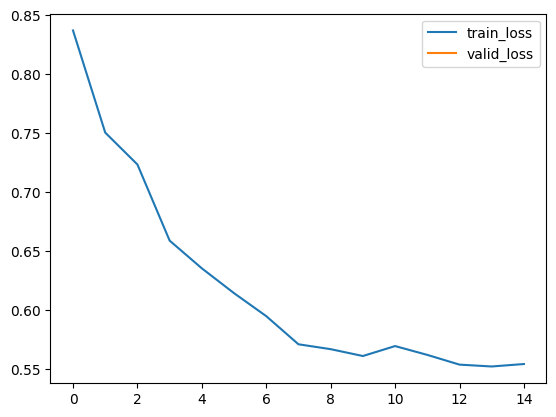

In [8]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

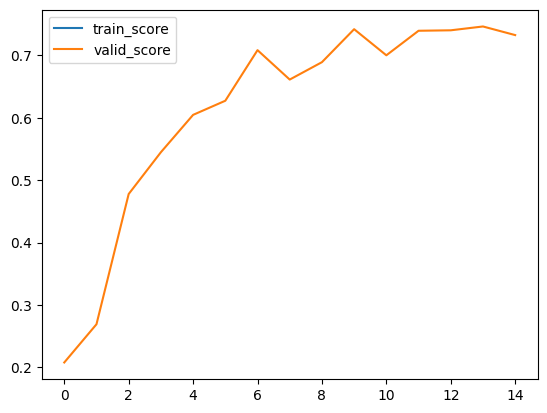

In [9]:
# train_scoreとvalid_scoreのプロット
plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [10]:
random.random()

0.972475841367452